In [1]:
import qiskit

In [2]:
pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to c:\users\anirudh\appdata\local\temp\pip-req-build-rnb2hnii

  Created wheel for qiskit-textbook: filename=qiskit_textbook-0.1.0-py3-none-any.whl size=17001 sha256=80bf8874d458a12a23dd3ba874cb395add3d10d5c63809a4780b5714309c728f
  Stored in directory: C:\Users\ANIRUDH\AppData\Local\Temp\pip-ephem-wheel-cache-im_9hveo\wheels\80\c4\dd\b7ea1ee2a7247e8997db78bc777bbe22e61ab1e5ed1c4b46e1
Successfully built qiskit-textbook


In [3]:
from qiskit import IBMQ
IBMQ.save_account('85fcd7bcb63cced65aa997fa07d08643b548aa65b022b872166f8ba05cfa35163b8817a8d6df9c723a00a37c9e0ae77a04a0c8b5b3faa22ac67ca79b32e6e7ba')
overwrite=True

configrc.store_credentials:WARNING:2020-12-06 16:47:04,573: Credentials already present. Set overwrite=True to overwrite.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

In [5]:
n = 2 
grover_circuit = QuantumCircuit(n)

In [6]:
def initialize_s(qc, qubits):
    for q in qubits:
        qc.h(q)
    return qc

In [7]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [8]:
grover_circuit.cz(0,1)
grover_circuit.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘

In [9]:
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

In [11]:
sv_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(grover_circuit, sv_sim)
statevec = job_sim.result().get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

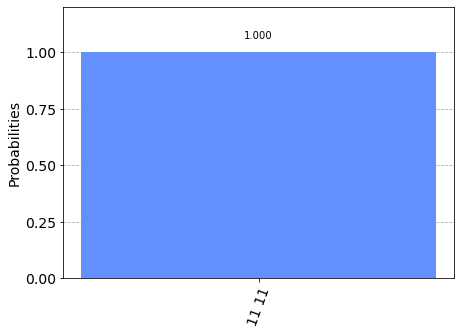

In [13]:
grover_circuit.measure_all()

qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [17]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

In [19]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [20]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U$_\omega$ ├┤1 $U_s$ ├─░──╫─┤M├───
        ├───┤│             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════╩══╩══╩═
                                          0  1  2

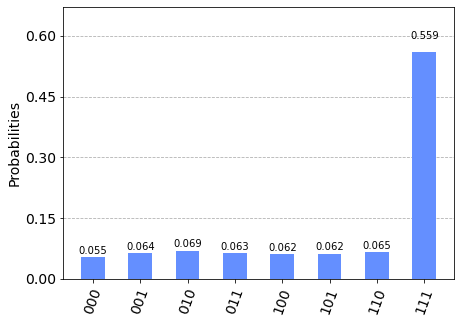

In [22]:
backend = Aer.get_backend('qasm_simulator')
results = execute(grover_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

In [23]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_valencia


In [24]:
from qiskit.tools.monitor import job_monitor
job = execute(grover_circuit, backend=backend, shots=1024, optimization_level=3)
job_monitor(job, interval =2)

Job Status: job has successfully run


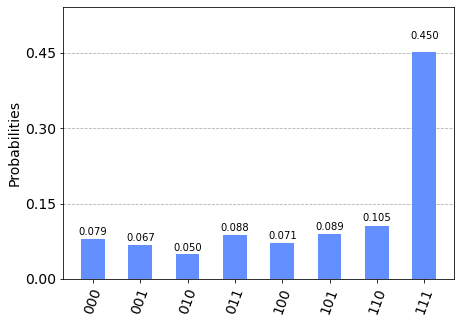

In [25]:
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

In [27]:
from qiskit_textbook.problems import grover_problem_oracle
n = 4
oracle = grover_problem_oracle(n, variant=1)
qc = QuantumCircuit(n)
qc.append(oracle, [0,1,2,3])
qc.draw()

┌────────────────────┐
q_0: ┤0                   ├
     │                    │
q_1: ┤1                   ├
     │  Oracle
n=4, var=1 │
q_2: ┤2                   ├
     │                    │
q_3: ┤3                   ├
     └────────────────────┘

In [28]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

In [31]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In [32]:
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

input_0: ──■───────
            │       
 input_1: ──┼────■──
          ┌─┴─┐┌─┴─┐
output_0: ┤ X ├┤ X ├
          └───┘└───┘

In [33]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
qc = QuantumCircuit(var_qubits, clause_qubits)
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1
qc.draw()

v_0: ──■─────────■───────────────────────────
       │         │                           
v_1: ──┼────■────┼─────────■─────────────────
       │    │    │         │                 
v_2: ──┼────┼────┼────■────┼─────────■───────
       │    │    │    │    │         │       
v_3: ──┼────┼────┼────┼────┼────■────┼────■──
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼──
                         └───┘└───┘┌─┴─┐┌─┴─┐
c_3: ──────────────────────────────┤ X ├┤ X ├
                                   └───┘└───┘

In [37]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1
qc.mct(clause_qubits, output_qubit)
qc.draw()

v_0: ──■─────────■────────────────────────────────
         │         │                                
  v_1: ──┼────■────┼─────────■──────────────────────
         │    │    │         │                      
  v_2: ──┼────┼────┼────■────┼─────────■────────────
         │    │    │    │    │         │            
  v_3: ──┼────┼────┼────┼────┼────■────┼────■───────
       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       
  c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──
       └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  
  c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■──
                 └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  
  c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──
                           └───┘└───┘┌─┴─┐┌─┴─┐  │  
  c_3: ──────────────────────────────┤ X ├┤ X ├──■──
                                     └───┘└───┘┌─┴─┐
out_0: ────────────────────────────────────────┤ X ├
                                               └───┘

In [39]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits)
qc.draw()

»
    v_0: ──■─────────■──────────────────────────────────■─────────■────────────»
           │         │                                  │         │            »
    v_1: ──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──»
           │    │    │         │                        │    │    │         │  »
    v_2: ──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼──»
           │    │    │    │    │         │              │    │    │    │    │  »
    v_3: ──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼──»
         ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │  »
    c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼──»
         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │  »
    c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼──»
                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐»
    c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├»
                             └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘»
    c_3: ──────────────────────────────┤ X ├┤ X ├──■───────────────────────────»
                                       └───┘└───┘┌─┴─┐                         »
  out_0: ────────────────────────────────────────┤ X ├─────────────────────────»
                                                 └───┘                         »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                        
«    v_0: ───────────────
«                        
«    v_1: ───────────────
«                        
«    v_2: ───────■───────
«                │       
«    v_3: ──■────┼────■──
«           │    │    │  
«    c_0: ──┼────┼────┼──
«           │    │    │  
«    c_1: ──┼────┼────┼──
«         ┌─┴─┐  │    │  
«    c_2: ┤ X ├──┼────┼──
«         └───┘┌─┴─┐┌─┴─┐
«    c_3: ─────┤ X ├┤ X ├
«              └───┘└───┘
«  out_0: ───────────────
«                        
«cbits: 4/═══════════════
«

In [40]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)
qc.initialize([1, -1]/np.sqrt(2), output_qubit)
qc.h(var_qubits)
qc.barrier()
sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits)
qc.barrier()
qc.append(diffuser(4), [0,1,2,3])
qc.measure(var_qubits, cbits)
qc.draw()

┌───┐               ░                                    »
    v_0: ─────────────┤ H ├───────────────░───■─────────■──────────────────────»
                      ├───┤               ░   │         │                      »
    v_1: ─────────────┤ H ├───────────────░───┼────■────┼─────────■────────────»
                      ├───┤               ░   │    │    │         │            »
    v_2: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼─────────■──»
                      ├───┤               ░   │    │    │    │    │         │  »
    v_3: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼──»
                      └───┘               ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │  »
    c_0: ─────────────────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼──»
                                          ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  »
    c_1: ─────────────────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼──»
                                          ░           └───┘└───┘┌─┴─┐┌─┴─┐  │  »
    c_2: ─────────────────────────────────░─────────────────────┤ X ├┤ X ├──┼──»
                                          ░                     └───┘└───┘┌─┴─┐»
    c_3: ─────────────────────────────────░───────────────────────────────┤ X ├»
         ┌──────────────────────────────┐ ░                               └───┘»
  out_0: ┤ initialize(0.70711,-0.70711) ├─░────────────────────────────────────»
         └──────────────────────────────┘ ░                                    »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                            ░ ┌────────┐┌─┐   »
«    v_0: ────────────■─────────■────────────────────────────░─┤0       ├┤M├───»
«                     │         │                            ░ │        │└╥┘┌─┐»
«    v_1: ────────────┼────■────┼─────────■──────────────────░─┤1       ├─╫─┤M├»
«                     │    │    │         │                  ░ │  $U_s$ │ ║ └╥┘»
«    v_2: ────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├─╫──╫─»
«                     │    │    │    │    │         │        ░ │        │ ║  ║ »
«    v_3: ──■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├─╫──╫─»
«           │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘ ║  ║ »
«    c_0: ──┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────╫──╫─»
«           │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░            ║  ║ »
«    c_1: ──┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░────────────╫──╫─»
«           │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░            ║  ║ »
«    c_2: ──┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░────────────╫──╫─»
«         ┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░            ║  ║ »
«    c_3: ┤ X ├──■────────────────────────────────┤ X ├┤ X ├─░────────────╫──╫─»
«         └───┘┌─┴─┐                              └───┘└───┘ ░            ║  ║ »
«  out_0: ─────┤ X ├─────────────────────────────────────────░────────────╫──╫─»
«              └───┘                                         ░            ║  ║ »
«cbits: 4/════════════════════════════════════════════════════════════════╩══╩═»
«                                                                         0  1 »
«               
«    v_0: ──────
«               
«    v_1: ──────
«         ┌─┐   
«    v_2: ┤M├───
«         └╥┘┌─┐
«    v_3: ─╫─┤M├
«          ║ └╥┘
«    c_0: ─╫──╫─
«          ║  ║ 
«    c_1: ─╫──╫─
«          ║  ║ 
«    c_2: ─╫──╫─
«          ║  ║ 
«    c_3: ─╫──╫─
«          ║  ║ 
«  out_0: ─╫──╫─
«          ║  ║ 
«cbits: 4/═╩══╩═
«          2  3

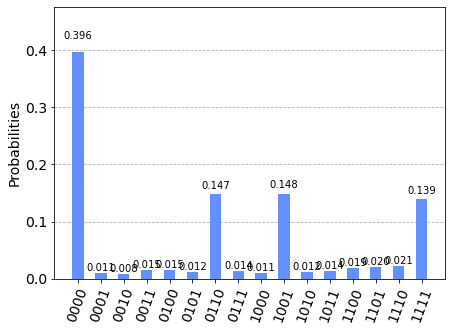

In [41]:
qasm_simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend=qasm_simulator, shots=1024).result()
plot_histogram(result.get_counts())